In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import gwent
import gwent.detector as detector
import gwent.binary as binary
import gwent.snr as snr

import hasasia.sensitivity as hsen
import hasasia.sim as hsim

from fargoAnalysis import *
from formatFuncs import *

In [3]:
plt.style.use('default')
plt.style.use('presentation')

plt.rcParams['lines.linewidth'] = 3

In [148]:
avals = np.logspace(1,6,1000)
mvals = np.logspace(5,10,1000)*u.solMass
qvals = np.logspace(-3,0,1000)

As, Ms = np.meshgrid(avals,mvals)
As, Qs = np.meshgrid(avals,qvals)

In [126]:
def t_binary(Mtot=1e8*u.solMass,a=100):
    rg = grv_const * Mtot / spd_lgt**2
    sep = a*rg
    
    tb = 2*np.pi * np.sqrt(sep**3/grv_const/Mtot)
    return tb
    

In [127]:
def r_gasrad(mtot,alpha,q=0,b=1):
    if b==1:
        c=0.482e3
    else:
        c=0.515e3
    return c * (alpha/0.3)**(2/21) * ((mtot.to(u.solMass).value/(1+q)/1e7)**(2/21))

def m_for_rgr(rgr,alpha,q=0,b=1): 
    if b==1:
        c=0.482e3
    else:
        c=0.515e3
        
    return 1e7 * (rgr/c)**(21/2) * (alpha/0.3)**(-1) * (1+q)    #need to factor in q to get from primary mass (which determines disk properties) to total binary mass
                                                                #this may be incongruent at large mass ratios where total mass is a better measure of "central object" setting disk props

In [128]:
def gapOpeningKocsis(sep=100,mtot=1e8*u.solMass,b=1,f=1e-2,alpha=0.01,mdot=0.1,q=0):
    
    m = mtot.to(u.solMass).value / (1+q) #convert total binary mass to primary mass
    
    r_gr = r_gasrad(mtot,alpha,b=b)
    print(r_gr.shape)
    if b==0: # not a beta disk #is mdot in mdot_edd? #is m central mass or binary mass?
        q1 = 4.5e-5 * (alpha/0.1)**0.5 * (mdot/0.1)**2.5 * (f/1e-2)**(-0.5) * (sep/100)**(-2.5)
        q2 = 5.7e-4 * (alpha/0.1) * (mdot/0.1)**2 * (f/1e-2)**(-1) * (sep/100)**(-2)
    else: # beta disk
        q1 = 2e-5 * (alpha/0.1)**0.4 * (mdot/0.1)**1.7 * (m/1e7)**(-0.1) * (f/1e-2)**(-0.5) * (sep/100)**(-29/20)
        q2 = 4e-5 * (alpha/0.1)**0.8 * (mdot/0.1)**0.4 * (m/1e7)**(-0.2) * (f/1e-2)**(-1) * (sep/100)**(0.1)

    q_thresh_rad = np.dstack((q1,q2)).squeeze().max(axis=q1.ndim)
    
    q1 = 1.7e-6 * (alpha/0.1)**0.25 * (mdot/0.1)**0.5 * (m/1e7)**(-0.25) * (f/1e-2)**(-0.5) * (sep/100)**(0.125)
    q2 = 4e-5 * (alpha/0.1)**0.8 * (mdot/0.1)**0.4 * (m/1e7)**(-0.2) * (f/1e-2)**(-1) * (sep/100)**(0.1)

    q_thresh_gas = np.dstack((q1,q2)).squeeze().max(axis=q1.ndim) #axis argument here is kludge-y but works
    print(q_thresh_rad.max(),q_thresh_gas.max())
    
    q_thresh = np.zeros(q_thresh_gas.shape)
    q_thresh[sep<r_gr] = q_thresh_rad[sep<r_gr]
    q_thresh[sep>=r_gr] = q_thresh_gas[sep>=r_gr]


    
    return q_thresh #still not sure this is right but don't understand why


def cavityKocsis_unsat(sep=100,mtot=1e8*u.solMass,b=1,f=1e-2,alpha=0.01,mdot=0.1,q=0):
    m = mtot.to(u.solMass).value / (1+q) #convert total binary mass to primary mass
    cavq = 4.7e-3 * (alpha/0.1)**(4/3) * (mdot/0.1)**(1/3) * (m/1e7)**(-2/3) * (f/1e-2)**(-4/3) * (sep/100)**(-1/3)
    
    
    return cavq

def cavityKocsis_unsat_sep(sep=100,mtot=1e8*u.solMass,b=1,f=1e-2,alpha=0.01,mdot=0.1,q=0):
    m = mtot.to(u.solMass).value / (1+q) #convert total binary mass to primary mass
    r_su = (4.7**3)*1e2 * (alpha/0.1)**(4) * (mdot/0.1) * (m/1e7)**(-2) * (f/1e-2)**(-4) * (q/1e-3)**(-3)

    return r_su

def cavityKocsis_sat(sep=100,mtot=1e8*u.solMass,b=1,f=1e-2,alpha=0.01,mdot=0.1,q=0,Wval=2):
    m = mtot.to(u.solMass).value / (1+q) #convert total binary mass to primary mass

    a = 0.465 * (alpha/0.1) * (m/1e7)**(-0.25) * (q/1e-3)**(-13/12) * (f/1e-2)**(-1.25) * (sep/100)**(5/8)
    
    sattorq = a > (1/np.exp(1)) # torque is saturated
        
    # print(a.max())
    # W = np.log(a) - np.log(-np.log(a))
    # print(a)
    # print(np.nanmin(W),np.nanmax(W),np.nanmean(W))
    
    W = Wval
    cavsep = 600 * (alpha/0.1)**(12/31) *  (m/1e7)**(-14/31) * (q/1e-3)**(3/31) * (f/1e-2)**(-4/31) * W**(-104/155)

    # cavq_sat = 1e-3 * 6**(-31/3) * (alpha/0.1)**(-4) *  (m/1e7)**(14/3) * (sep/1e2)**(31/3) * (f/1e-2)**(4/3) * W**(104/15)
    # cavq_uns = 4.7e-3 * (alpha/0.1)**(4/3) * (mdot/0.1)**(1/3) * (m/1e7)**(-2/3) * (f/1e-2)**(-4/3) * (sep/100)**(-1/3)
   
    # return nan_to_num(cavq_sat,0.0)*sattorq #+ cavq_uns*np.logical_not(sattorq)
    return cavsep


In [129]:
#Haiman et al. 2009 zone transition radii
#factors of 2 here are because H09 radii are in terms of Schwarzschild radius, but we want in terms of R_g

#free-free opacity -> electron scattering
def r_esff(mdot=0.1,accr_eff=0.1,mu_0=1,f_T=0.75,kappa_ff=0.5,kappa_es=0.5): #Haiman leaves the kappas in the formulation, but 
                                                                             #by definition they are equal at this interface,
                                                                             #so mustn't they both be 0.5?
            
    return 2*4.1e3 * mu_0**(-1/3) * f_T**(17/12) * (kappa_ff/kappa_es)**(-2/3) * (mdot/accr_eff)**(2/3)



#disk-dominated migration -> secondary-dominated
def r_snu_a(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1):
    q_s = 4*q / (1+q)**2

    return 2*3.61e3 * mu_e**(2/7) * kappa_es**(4/7) * f_T**(4/7) * (alpha/0.3)**(2/7) * (mdot/accr_eff)**(2/7) * (M/1e7)**(-2/7) * q_s**(2/7) * lamb**(-1)

def r_snu_b(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1):
    q_s = 4*q / (1+q)**2

    return 2*1.21e5 * mu_e**(4/7) * mu_0**(-4/7) * kappa_es**(1/7) * f_T**(10/7) * (alpha/0.3)**(4/7) * (mdot/accr_eff)**(-3/7) * (M/1e7)**(-6/7) * q_s**(5/7) * lamb**(-1)

def r_snu_c(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1):
    q_s = 4*q / (1+q)**2

    return 2*1.82e5 * mu_e**(16/25) * mu_0**(-3/5) * kappa_ff**(2/25) * f_T**(143/100) * (alpha/0.3)**(16/25) * (mdot/accr_eff)**(-14/25) * (M/1e7)**(-24/25) * q_s**(4/5) * lamb**(-1)



#secondary-dominated migration -> GW-dominated
def r_sgw_a(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1,beta_gw=1): #beta_gw=1 for initial takeover of GW over disk; ~0.1 for decoupling
    q_s = 4*q / (1+q)**2
    
    return 2*0.587e3 * mu_e**(6/29) * kappa_es**(-20/29) * f_T**(-20/29) * (alpha/0.3)**(-10/29) * (mdot/accr_eff)**(-26/29) * (M/1e7)**(-6/29) * q_s**(22/29) * lamb**(35/29) * beta_gw**(16/29)

def r_sgw_b(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1,beta_gw=1):
    q_s = 4*q / (1+q)**2
    
    return 2*0.470e3 * mu_e**(4/25) * mu_0**(-4/25) * kappa_es**(-1/25) * f_T**(-2/25) * (alpha/0.3)**(-4/25) * (mdot/accr_eff)**(-1/5) * (M/1e7)**(-2/25) * q_s**(11/25) * lamb**(7/25) * beta_gw**(8/25)

def r_sgw_c(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1,beta_gw=1):
    q_s = 4*q / (1+q)**2
    
    return 2*0.545e3 * mu_e**(6/37) * mu_0**(-5/37) * kappa_ff**(-2/111) * f_T**(-143/444) * (alpha/0.3)**(-16/111) * (mdot/accr_eff)**(-20/111) * (M/1e7)**(-10/111) * q_s**(16/37) * lamb**(25/111) * beta_gw**(34/111)


#disk-dominated migration -> GW-dominated (should be rare to skip the sec-dom phase, but can happen for very massive q~1 SMBHBs)
def r_gwnu_a(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1,beta_gw=1):
    q_s = 4*q / (1+q)**2

    return 2*0.202e3 * kappa_es**(-4) * f_T**(-4) * (alpha/0.3)**(-2) * (mdot/accr_eff)**(-4) * q_s**(2) * lamb**(7) * beta_gw**(2)

def r_gwnu_b(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1):
    q_s = 4*q / (1+q)**2

    return 2*0.222e3 * mu_e**(1/13) * mu_0**(4/13) * kappa_es**(-1/13) * f_T**(-10/13) * (alpha/0.3)**(-4/13) * (mdot/accr_eff)**(-2/13) * (M/1e7)**(1/13) * q_s**(5/13) * lamb**(7/13) * beta_gw**(5/13)

def r_gwnu_c(M,q,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1):
    q_s = 4*q / (1+q)**2

    return 2*0.183e3 * mu_e**(4/55) * mu_0**(3/11) * kappa_ff**(-2/55) * f_T**(-13/20) * (alpha/0.3)**(-16/55) * (mdot/accr_eff)**(-6/55) * (M/1e7)**(4/55) * q_s**(4/11) * lamb**(5/11) * beta_gw**(4/11)

In [130]:
def t_gw_int(rmax,rmin=0,m=1e7*u.solMass,q=1.0):
    q_s = 4*q / (1+q)**2
    term1 = 1.25 * grv_const * spd_lgt**(-3)

    #divisions to get r in terms of R_S instead of R_g, as R_S is expected for H09 formulae
    rmax /= 2
    rmin /= 2
    
    return (term1 * (m / q_s) * (rmax**4 - rmin**4)).to(u.yr)

In [131]:
def t_nu_int_a(rmax,rmin=0,m=1e7*u.solMass,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    term1 = 2.82e7*u.yr
    term2 = kappa_es**(-2) * f_T**(-2)
    term3 = (alpha/0.3)**(-1) * (mdot/accr_eff)**(-2) * (m.to(u.solMass).value/1e7) * lamb**(3.5)
    int_term = (2/7) * ((rmax/2e3)**3.5 - (rmin/2e3)**3.5) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)

def t_nu_int_b(rmax,rmin=0,m=1e7*u.solMass,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    term1 = 5.96e4*u.yr
    term2 = mu_e**0.2 * mu_0**0.8 * kappa_es**(-0.2) * f_T**(-2)
    term3 = (alpha/0.3)**(-0.8) * (mdot/accr_eff)**(-0.4) * (m.to(u.solMass).value/1e7)**(1.2) * lamb**(1.4)
    int_term = (5/7) * ((rmax/2e3)**(7/5) - (rmin/2e3)**(7/5)) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)

def t_nu_int_c(rmax,rmin=0,m=1e7*u.solMass,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    term1 = 7.37e4*u.yr
    term2 = mu_e**0.2 * mu_0**0.75 * kappa_ff**(-0.1) * f_T**(-143/80)
    term3 = (alpha/0.3)**(-0.8) * (mdot/accr_eff)**(-0.3) * (m.to(u.solMass).value/1e7)**(1.2) * lamb**(1.25)
    int_term = (0.8) * ((rmax/2e3)**(1.25) - (rmin/2e3)**(1.25)) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)
    

In [132]:
def t_s_int_a(rmax,rmin=0,m=1e7*u.solMass,q=1.0,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    q_s = 4*q / (1+q)**2
    
    term1 = 6.15e6*u.yr
    term2 = mu_e**(3/8) * kappa_es**(-1.25) * f_T**(-1.25)
    term3 = (alpha/0.3)**(-5/8) * (mdot/accr_eff)**(-13/8) * (m.to(u.solMass).value/1e7)**(5/8) * q_s**(3/8) * lamb**(35/16)
    int_term = (16/35) * ((rmax/2e3)**(35/16) - (rmin/2e3)**(35/16)) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)

def t_s_int_b(rmax,rmin=0,m=1e7*u.solMass,q=1.0,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    q_s = 4*q / (1+q)**2
    
    term1 = 7.40e5*u.yr
    term2 = mu_e**0.5 * mu_0**0.5 * kappa_es**(-1/8) * f_T**(-1.25)
    term3 = (alpha/0.3)**(-0.5) * (mdot/accr_eff)**(-5/8) * (m.to(u.solMass).value/1e7)**(0.75) * q_s**(3/8) * lamb**(7/8)
    int_term = (8/7) * ((rmax/2e3)**(7/8) - (rmin/2e3)**(7/8)) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)

def t_s_int_c(rmax,rmin=0,m=1e7*u.solMass,q=1.0,alpha=0.01,f_T=0.75,kappa_es=1,kappa_ff=1,mdot=0.1,accr_eff=0.1,lamb=1.0,mu_e=1,mu_0=1):
    q_s = 4*q / (1+q)**2
    
    term1 = 1.07e6*u.yr
    term2 = mu_e**(9/17) * mu_0**(15/34) * kappa_ff**(-1/17) * f_T**(-143/136)
    term3 = (alpha/0.3)**(-8/17) * (mdot/accr_eff)**(-10/17) * (m.to(u.solMass).value/1e7)**(12/17) * q_s**(7/17) * lamb**(25/34)
    int_term = (34/25) * ((rmax/2e3)**(25/34) - (rmin/2e3)**(25/34)) #we divide by 2e3 to convert to units of 1000 R_S, as in H09
    
    return (term1*term2*term3*int_term).to(u.yr)
    

In [133]:
def get_migzones(r,diskzone,nusa,nusb,nusc,sgwa,sgwb,sgwc,nugwa,nugwb,nugwc):
    #if r>nus & r>nugw, then t_nu
    #if nus>nugw, then s zone can exist => if (nus>nugw)&(r<nus)&(r>sgw) then t_s
    #if (nus>nugw)&(r<nus)&(r<sgw) OR (nus<nugw)&(r<nugw) then t_gw
    nu_zone  = np.logical_and(np.logical_and(diskzone==1,r>nusa),r>nugwa)
    nu_zone += np.logical_and(np.logical_and(diskzone==2,r>nusb),r>nugwb)
    nu_zone += np.logical_and(np.logical_and(diskzone==3,r>nusc),r>nugwc)
    
    s_zone  = np.logical_and(np.logical_and(np.logical_and(diskzone==1,nusa>nugwa),r>sgwa),r<=nusa)
    s_zone += np.logical_and(np.logical_and(np.logical_and(diskzone==2,nusb>nugwb),r>sgwb),r<=nusb)
    s_zone += np.logical_and(np.logical_and(np.logical_and(diskzone==3,nusc>nugwc),r>sgwc),r<=nusc)
    
    gw_zone  = np.logical_and(np.logical_and(np.logical_and(diskzone==1,nusa>nugwa),r<=sgwa),r<=nusa)
    gw_zone += np.logical_and(np.logical_and(np.logical_and(diskzone==2,nusb>nugwb),r<=sgwb),r<=nusb)
    gw_zone += np.logical_and(np.logical_and(np.logical_and(diskzone==3,nusc>nugwc),r<=sgwc),r<=nusc)
    gw_zone += np.logical_and(np.logical_and(diskzone==1,nusa<=nugwa),r<nugwa)
    gw_zone += np.logical_and(np.logical_and(diskzone==2,nusb<=nugwb),r<nugwb)
    gw_zone += np.logical_and(np.logical_and(diskzone==3,nusc<=nugwc),r<nugwc)

    migzone = gw_zone*1 + s_zone*2 + nu_zone*3
    return migzone

def residence_timescale(rmax,rmin=0,m=1e7*u.solMass,q=1.0,mu_e=1,mu_0=1,kappa_es=1,kappa_ff=1,f_T=0.75,alpha=0.01,mdot=0.1,accr_eff=0.1,lamb=1,beta_gw=1,b=0,onezone=True):
    # need to calculate, for binary/disk parameters, where the region interfaces are
    # then determine what region we're strating in, and which regions are crossed when so the integration bounds can be split correctly
    
    r_gr = r_gasrad(m,alpha,b)
    r_op = r_esff(mdot,accr_eff,mu_0,f_T)
    
    #disk-dom to sec-dom
    nusa = r_snu_a(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb)
    nusb = r_snu_b(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb)
    nusc = r_snu_b(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb)
    
    #sec-dom to gw-dom
    sgwa = r_sgw_a(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    sgwb = r_sgw_b(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    sgwc = r_sgw_c(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    
    #disk-dom to gw-dom (should only occur for very large M and q~1)
    nugwa = r_sgw_a(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    nugwb = r_sgw_b(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    nugwc = r_sgw_c(m.to(u.solMass).value,q,mu_e,mu_0,kappa_es,kappa_ff,f_T,alpha,mdot,accr_eff,lamb,beta_gw)
    

    #step one, which disk zone is the secondary starting and ending in?
    if b==0:
        diskzone  = (rmax<r_gr)*1 + np.logical_and(rmax<=r_op,rmax>=r_gr)*2 + (rmax>r_op)*3
        diskzone2 = (rmin<r_gr)*1 + np.logical_and(rmin<=r_op,rmin>=r_gr)*2 + (rmin>r_op)*3
    else:
        diskzone = np.logical_and(rmax<=r_op,rmax>=r_gr)*2 + (rmax>r_op)*3
        diskzone2 = np.logical_and(rmin<=r_op,rmin>=r_gr)*2 + (rmin>r_op)*3
    
    # print(nusa,rmin)

    #step two, which migration regime is the secondary starting and ending in?
    #if r>nus & r>nugw, then t_nu
    #if nus>nugw, then s zone can exist => if (nus>nugw)&(r<nus)&(r>sgw) then t_s
    #if (nus>nugw)&(r<nus)&(r<sgw) OR (nus<nugw)&(r<nugw) then t_gw
    migzone  = get_migzones(rmax,diskzone,nusa,nusb,nusc,sgwa,sgwb,sgwc,nugwa,nugwb,nugwc)
    migzone2 = get_migzones(rmin,diskzone2,nusa,nusb,nusc,sgwa,sgwb,sgwc,nugwa,nugwb,nugwc)
    # print((nugwa>nusa).sum(),(nugwb>nusb).sum(),(nugwc>nusc).sum())
    
    if onezone:
        inttime  = (migzone==1)*t_gw_int(rmax,rmin,m,q)
        
        inttime += (migzone==2)*(diskzone==1) * t_s_int_a(rmax,rmin,m,q,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
        inttime += (migzone==2)*(diskzone==2) * t_s_int_b(rmax,rmin,m,q,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
        inttime += (migzone==2)*(diskzone==3) * t_s_int_c(rmax,rmin,m,q,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
        
        inttime += (migzone==3)*(diskzone==1) * t_nu_int_a(rmax,rmin,m,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
        inttime += (migzone==3)*(diskzone==2) * t_nu_int_b(rmax,rmin,m,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
        inttime += (migzone==3)*(diskzone==3) * t_nu_int_c(rmax,rmin,m,alpha,f_T,kappa_es,kappa_ff,mdot,accr_eff,lamb,mu_e,mu_0)
    
    return inttime

In [33]:
Qs, Ms = np.meshgrid(qvals,mvals)

gr_1 = r_gasrad(Ms,0.01,b=1)
gr_0 = r_gasrad(Ms,0.01,b=0)

In [150]:
q = 1.0
alpha = 0.01#0.01

tbinvals = t_binary(Ms,As).to(u.yr)
m_rgr    = m_for_rgr(avals,alpha,q,)
rgr      = r_gasrad(mvals,alpha,q)
gap_q    = gapOpeningKocsis(As,Ms,alpha=1,q=q,b=0,)
cav_q    = cavityKocsis_unsat(As,Ms,alpha=alpha,q=q,b=0,)
cav_rs   = cavityKocsis_sat(avals,mvals,alpha=alpha,q=q,b=0,Wval=100)
cav_ru   = cavityKocsis_unsat_sep(avals,mvals,alpha=alpha,q=q,b=0,)

# r_snua = r_snu_a(mvals.value,q,)
# r_snub = r_snu_b(mvals.value,q,)
# r_snuc = r_snu_c(mvals.value,q,)

# r_sgwa = r_sgw_a(mvals.value,q,)
# r_sgwb = r_sgw_b(mvals.value,q,)
# r_sgwc = r_sgw_c(mvals.value,q,)

restime99 = residence_timescale(As,0.99*As,m=Ms,q=q)/tbinvals

(1000, 1000)
0.57 0.0018292202077093058


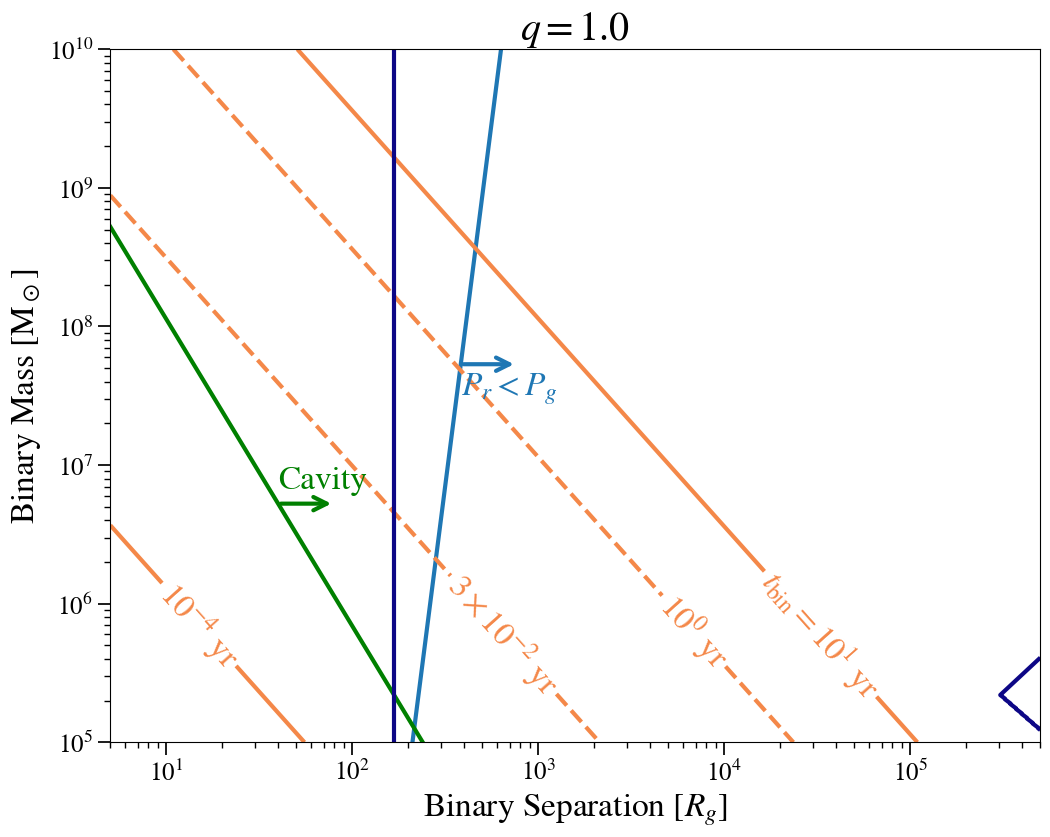

In [151]:
fig,ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

line = plt.plot(rgr,mvals.value)[0]
add_arrow(line,direction='right',label=r'$P_r<P_g$',size=24,ytext=0.6)

line2 = plt.plot(np.max([cav_rs,cav_ru],axis=0),mvals.value,color='g')[0]
add_arrow(line2,direction='right',label=r'Cavity',size=24,ytext=1.3,position=4e1)
# plt.plot(r_snua,mvals.value,color=darkblue)
# plt.plot(r_snub,mvals.value,color=midpurp)
# plt.plot(r_snuc,mvals.value,color='g')

# plt.plot(r_snua[np.where(r_snua<rgr)],mvals.value[np.where(r_snua<rgr)],color=darkblue)
# plt.plot(r_snub[np.where(np.logical_and(r_snua>=rgr,r_snub<=esff))],mvals.value[np.where(np.logical_and(r_snua>=rgr,r_snub<=esff))],color=midpurp)
# plt.plot(r_snuc[np.where(r_snuc>esff)],mvals.value[np.where(r_snuc>esff)],color=darkblue)

# plt.plot(r_sgwa,mvals.value,color=darkblue)
# plt.plot(r_sgwb,mvals.value,color=midpurp)
# plt.plot(r_sgwc,mvals.value,color='g')

# line2 = plt.plot(np.max([cav_rs,cav_ru],axis=0),mvals.value,color='g')[0]
# add_arrow(line2,direction='right',label=r'Cavity',size=24,ytext=1.3,position=4e1)

C2 = ax.contour(As,Ms,tbinvals,[(1*u.h/(1*u.yr)),(10*u.d/(1*u.yr)),1,10],colors=coolorange,linestyles=['-','--','--','-'])
# C3 = ax.contour(As,Ms,cav_q,[q],colors='g')
C4 = ax.contour(As,Ms,restime99,[1e3],colors=darkblue)

# plt.axvline(esff)

pos2a = [(5e4,1e6)]
pos2b = [(2e1,1e6),(1e3,1e6),(1e4,1e6),]

# ax.clabel(C1a,inline=True,fmt=FuncFormatter(fmt_tres),manual=pos1a)
# ax.clabel(C1b,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos1b)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_tbin),manual=pos2a)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos2b)


ax.set_ylabel('Binary Mass [M$_\odot$]')
ax.set_xlabel('Binary Separation [$R_g$]')
ax.set_title(f'$q={q}$')#,color=nordwhite)

ax.set_ylim(1e5,1e10)
plt.show()

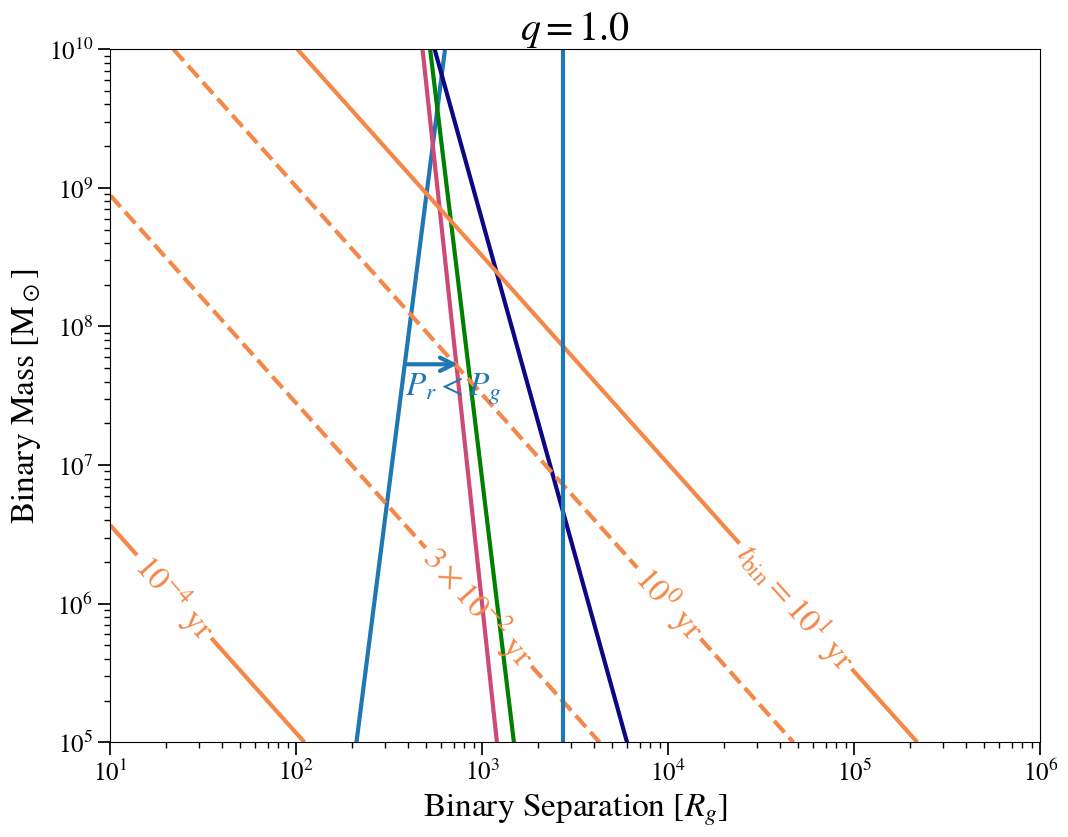

In [49]:
fig,ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

line = plt.plot(rgr,mvals.value)[0]
add_arrow(line,direction='right',label=r'$P_r<P_g$',size=24,ytext=0.6)


plt.plot(r_sgwa,mvals.value,color=darkblue)
plt.plot(r_sgwb,mvals.value,color=midpurp)
plt.plot(r_sgwc,mvals.value,color='g')

# line2 = plt.plot(np.max([cav_rs,cav_ru],axis=0),mvals.value,color='g')[0]
# add_arrow(line2,direction='right',label=r'Cavity',size=24,ytext=1.3,position=4e1)

C2 = ax.contour(As,Ms,tbinvals,[(1*u.h/(1*u.yr)),(10*u.d/(1*u.yr)),1,10],colors=coolorange,linestyles=['-','--','--','-'])
# C3 = ax.contour(As,Ms,cav_q,[q],colors='g')

plt.axvline(esff)

pos2a = [(5e4,1e6)]
pos2b = [(2e1,1e6),(1e3,1e6),(1e4,1e6),]

# ax.clabel(C1a,inline=True,fmt=FuncFormatter(fmt_tres),manual=pos1a)
# ax.clabel(C1b,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos1b)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_tbin),manual=pos2a)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos2b)


ax.set_ylabel('Binary Mass [M$_\odot$]')
ax.set_xlabel('Binary Separation [$R_g$]')
ax.set_title(f'$q={q}$')#,color=nordwhite)

ax.set_ylim(1e5,1e10)
plt.show()

In [152]:
q = 1.0e-3
alpha = 0.01

tbinvals = t_binary(Ms,As).to(u.yr)
m_rgr    = m_for_rgr(avals,alpha,q,)
rgr      = r_gasrad(mvals,alpha,q)
gap_q    = gapOpeningKocsis(As,Ms,alpha=1,q=q,b=1)
cav_q    = cavityKocsis_unsat(As,Ms,alpha=alpha,q=q,b=0,)
cav_rs   = cavityKocsis_sat(avals,mvals,alpha=alpha,q=q,b=0,Wval=2)
cav_ru = cavityKocsis_unsat_sep(avals,mvals,alpha=alpha,q=q,b=0)

# r_snua = r_snu_a(mvals.value,q,)
# r_snub = r_snu_b(mvals.value,q,)
# r_snuc = r_snu_c(mvals.value,q,)

# r_sgwa = r_sgw_a(mvals.value,q,)
# r_sgwb = r_sgw_b(mvals.value,q,)
# r_sgwc = r_sgw_c(mvals.value,q,)

restime99 = residence_timescale(As,0.99*As,m=Ms,q=q)/tbinvals

(1000, 1000)
0.006131502322826832 0.0014860855360827574


(10.0, 100000.0)

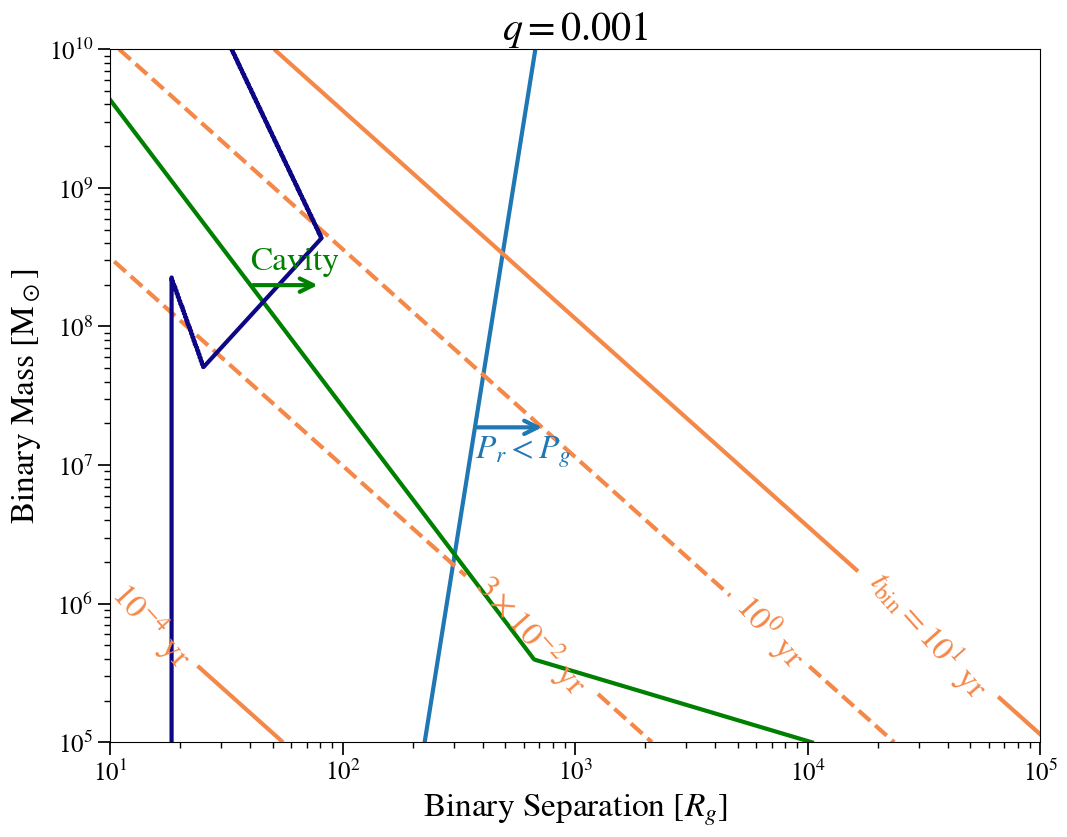

In [153]:
fig,ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

# plt.axvline(esff)
line = plt.plot(rgr,mvals.value)[0]
add_arrow(line,direction='right',label=r'$P_r<P_g$',size=24,ytext=0.6,position=3.7e2)

line2 = plt.plot(np.max([cav_rs,cav_ru],axis=0),mvals.value,color='g')[0]
add_arrow(line2,direction='right',label=r'Cavity',size=24,ytext=1.3,position=4e1)

# plt.plot(r_snua[np.where(r_snua<rgr)],mvals.value[np.where(r_snua<rgr)],color=darkblue)
# plt.plot(r_snub[np.where(np.logical_and(r_snua>=rgr,r_snub<=esff))],mvals.value[np.where(np.logical_and(r_snua>=rgr,r_snub<=esff))],color=midpurp)
# plt.plot(r_snuc[np.where(r_snuc>esff)],mvals.value[np.where(r_snuc>esff)],color=darkblue)



# plt.plot(r_sgwa,mvals.value,color=darkblue)
# plt.plot(r_sgwb,mvals.value,color=midpurp)
# plt.plot(r_sgwc,mvals.value,color='g')

# line3 = plt.plot(cav_ru,mvals.value,color='g')
# line3b = plt.plot(cav_rs,mvals.value,color='g')

C2 = ax.contour(As,Ms,tbinvals,[(1*u.h/(1*u.yr)),(10*u.d/(1*u.yr)),1,10],colors=coolorange,linestyles=['-','--','--','-'])
# C3 = ax.contour(As,Ms,cav_q,[q],colors='g')
C4 = ax.contour(As,Ms,restime99,[1e3],colors=darkblue)

# C4 = ax.contour(As,Ms,cav_r,[q],colors='g')

pos2a = [(5e4,1e6)]
pos2b = [(2e1,1e6),(1e3,1e6),(1e4,1e6),]

# ax.clabel(C1a,inline=True,fmt=FuncFormatter(fmt_tres),manual=pos1a)
# ax.clabel(C1b,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos1b)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_tbin),manual=pos2a)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos2b)


ax.set_ylabel('Binary Mass [M$_\odot$]')
ax.set_xlabel('Binary Separation [$R_g$]')
ax.set_title(f'$q={q}$')#,color=nordwhite)

ax.set_ylim(1e5,1e10)
ax.set_xlim(1e1,1e5)

(10.0, 100000.0)

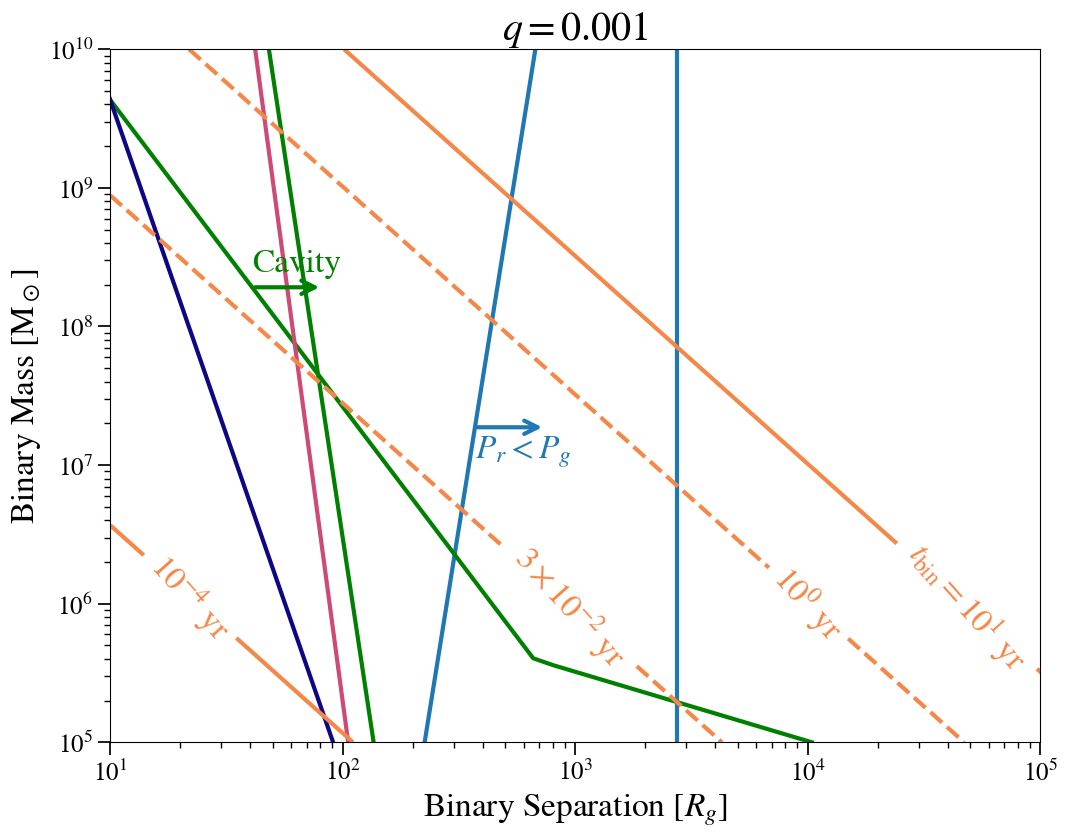

In [53]:
fig,ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

plt.axvline(esff)
line = plt.plot(rgr,mvals.value)[0]
add_arrow(line,direction='right',label=r'$P_r<P_g$',size=24,ytext=0.6,position=3.7e2)

line2 = plt.plot(np.max([cav_rs,cav_ru],axis=0),mvals.value,color='g')[0]
add_arrow(line2,direction='right',label=r'Cavity',size=24,ytext=1.3,position=4e1)

plt.plot(r_sgwa,mvals.value,color=darkblue)
plt.plot(r_sgwb,mvals.value,color=midpurp)
plt.plot(r_sgwc,mvals.value,color='g')

# line3 = plt.plot(cav_ru,mvals.value,color='g')
# line3b = plt.plot(cav_rs,mvals.value,color='g')

C2 = ax.contour(As,Ms,tbinvals,[(1*u.h/(1*u.yr)),(10*u.d/(1*u.yr)),1,10],colors=coolorange,linestyles=['-','--','--','-'])
# C3 = ax.contour(As,Ms,cav_q,[q],colors='g')

# C4 = ax.contour(As,Ms,cav_r,[q],colors='g')

pos2a = [(5e4,1e6)]
pos2b = [(2e1,1e6),(1e3,1e6),(1e4,1e6),]

# ax.clabel(C1a,inline=True,fmt=FuncFormatter(fmt_tres),manual=pos1a)
# ax.clabel(C1b,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos1b)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_tbin),manual=pos2a)
ax.clabel(C2,inline=True,fmt=FuncFormatter(fmt_yr),manual=pos2b)


ax.set_ylabel('Binary Mass [M$_\odot$]')
ax.set_xlabel('Binary Separation [$R_g$]')
ax.set_title(f'$q={q}$')#,color=nordwhite)

ax.set_ylim(1e5,1e10)
ax.set_xlim(1e1,1e5)